In [3]:
% pylab inline
import pandas as pd
#import numpy as np
import matplotlib as plt
import nltk
from nltk.corpus import stopwords 
import string
import heapq
import operator
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /home/oleg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/oleg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
import pandas as pd
data_df=pd.read_csv('gender-classifier-DFE-791531.csv',header=0,encoding = "ISO-8859-1")

In [38]:
def clean(words_string):    
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    stop_free=" ".join([i for i in words_string.lower().split() if i not in stop])
    punc_free=''.join(ch if ch not in exclude else ' ' for ch in stop_free)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

def uniteLists(list_of_lists_of_words):
    united=[]
    for list_of_words in list_of_lists_of_words:
        united+=list_of_words
    return united
def devideToTermsAndFreq(tfList):
    ans_terms=[]
    ans_freq=[]
    for key,val in tfList:
        ans_terms.append(key)
        ans_freq.append(val)
    return ans_terms,ans_freq
def createPlot(x_data,y_data,x_name,y_name,title,i,j,k):
    df=pd.DataFrame(data={x_name:x_data,y_name:y_data})
    temp = df.pivot_table(values=y_name,index=x_name)
    ax = fig.add_subplot(i,j,k) #121
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(title)
    temp.plot(kind='bar',ax=ax)

### cleaning the data

In [7]:
import re
data_df = data_df[data_df['gender'].apply(lambda x : (x=='male' or x=='female') )]
data_df['text']=data_df['text'].apply(lambda x :  re.sub('(htt\S+)',"",x))
data_df['text']=data_df['text'].apply(lambda x :  re.sub('[^a-zA-Z0-9 #@]+',"",x))
data_df['hashtags']=data_df['text'].apply(lambda x :  re.findall('#[a-zA-Z]+',x))
data_df['user_tag']=data_df['text'].apply(lambda x :  re.findall('@[a-zA-Z]+',x))
data_df['clean_text']=data_df['text'].apply(lambda x :  re.sub('[#@]\S+\s*',"",x))
data_df['clean_text']=data_df['clean_text'].apply(clean)
data_df['clean_text']=data_df['clean_text'].apply(lambda x:re.findall('[a-zA-Z0-9]+',x))

### male/female_tf contains all the terms with there frequencies. 

In [16]:
male_text=uniteLists(data_df['clean_text'][data_df['gender'].apply(lambda x: x=='male')])
female_text=uniteLists(data_df['clean_text'][data_df['gender'].apply(lambda x: x=='female')])
male_tf = Counter(male_text).most_common()
female_tf=Counter(female_text).most_common()


### plot of the 10 most common terms for male and female

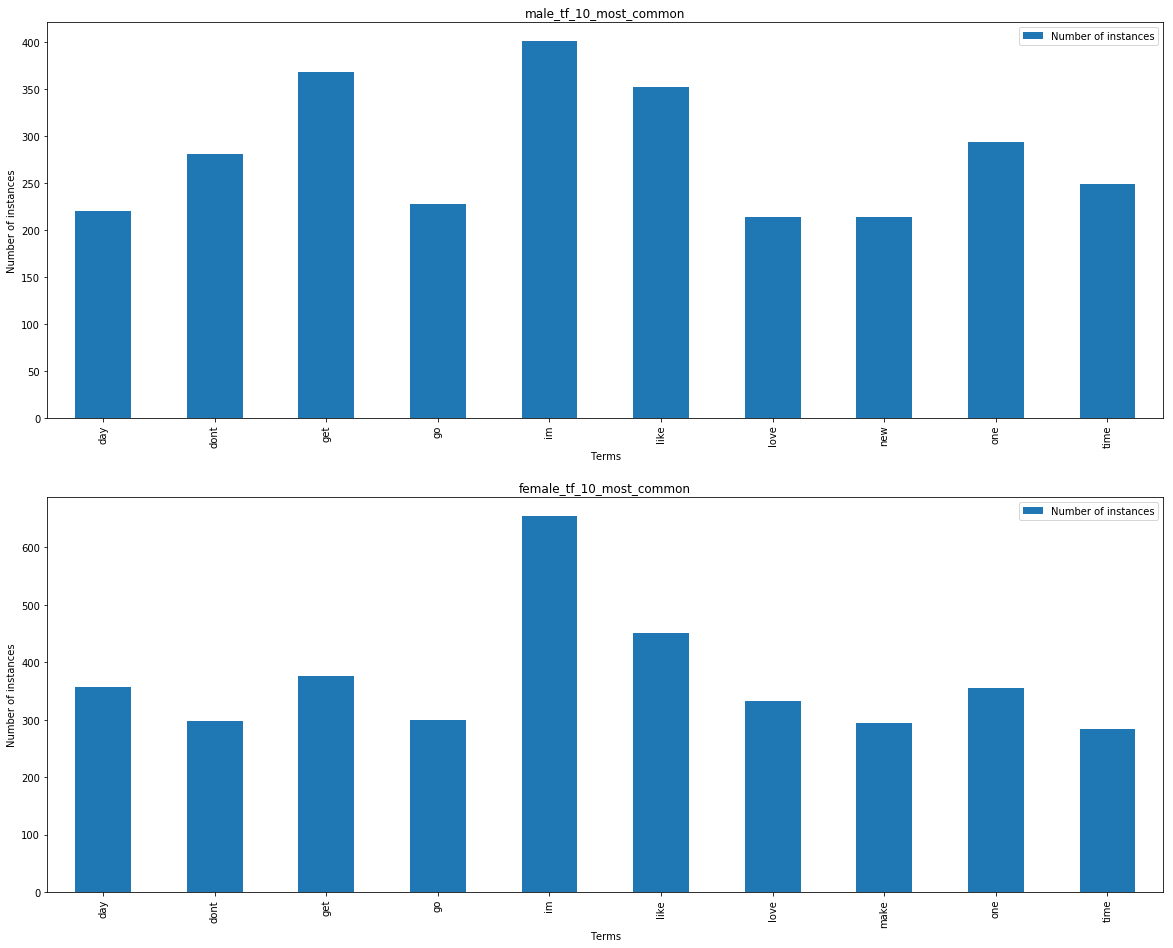

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_tf)
createPlot(terms[:10],freq[:10],'Terms','Number of instances','male_tf_10_most_common',2,1,1)
terms,freq=devideToTermsAndFreq(female_tf)
createPlot(terms[:10],freq[:10],'Terms','Number of instances','female_tf_10_most_common',2,1,2)

# /////////////////////////////////////////////////////////////////////////////////////////////////////////

In [31]:
text_list=data_df['text'].tolist()
gender_list=data_df['gender'].tolist()
data_df['tweet_count'][data_df['gender'].apply(lambda x: x=='female')].median()



9459.0

In [173]:
def clean(data, categories):
    '''
    Returns cleaned and normalized documents as shown in class.
    '''
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    cleaned_train_with_category = []
    for doc, target in zip(data, categories):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch if ch not in exclude else ' ' for ch in stop_free)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        cleaned_train_with_category.append((normalized.split(),target))
    return cleaned_train_with_category

def count_terms_in_categories(cleaned_train_with_category, categories):
    '''
    for every category, counts the number of times each term has been used,
    uses a dictionary of category-dictionaries
    '''
    # an array with the size of the number of dictionaries, 
    # each dictionary holds a dictionary that maps every term to the number of times it is used
    categories_dictionaries = {}
    # initialize all categories
    for category in categories:
        categories_dictionaries[category] = {}
    for (terms, category) in cleaned_train_with_category:
        for term in terms:
            if term in categories_dictionaries[category]:
                categories_dictionaries[category][term] = categories_dictionaries[category][term] + 1
            else:
                categories_dictionaries[category][term] = 1
    return categories_dictionaries

def order_asc(categories_dictionaries):
    '''
    Using heaps, stores for each category its 10 most used terms
    '''
    top_10_terms = {}
    for category, terms in categories_dictionaries.iteritems():
        heap = [(-value, key) for key,value in terms.items()]
        largest = heapq.nsmallest(10, heap)
        largest = [key for value, key in largest] #[(key, -value) for value, key in largest]
        top_10_terms[category] = largest
    return top_10_terms